In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from music21 import converter, instrument, note, chord, stream, midi, duration
import numpy as np
import os
import random
import pandas as pd
from matplotlib import pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def load_chorales(filepaths):
    files=os.listdir(filepaths)
    return [pd.read_csv(filepaths+file).values.tolist() for file in files]

train_chorales = load_chorales("/content/drive/My Drive/bach/jsb_chorales/train/")
valid_chorales = load_chorales("/content/drive/My Drive/bach/jsb_chorales/valid/")
test_chorales = load_chorales("/content/drive/My Drive/bach/jsb_chorales/test/")

In [ ]:
print(np.shape(train_chorales))
print(np.shape(valid_chorales))
print(np.shape(test_chorales))
print(np.shape(train_chorales[0]))

(229,)
(76,)
(77,)
(196, 4)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
# 資料的x與y
def make_data(data,batch_size):
  data_chords = data[0]
  for i in range(len(data)-1):
    data_chords = np.append(data_chords,data[i],axis=0)
  print(data_chords[0])
  data_notes = np.reshape(data_chords,(-1))
  print(data_notes[0:4])
  #print(np.shape(data_chords)) # chords數量*4
  data_notes = np.where(data_notes == 0, data_notes, data_notes - 35)
  print(max(data_notes))
  print(min(data_notes))
  sequence_length = batch_size #32 chords -> 128 notes
  
  index = list(range(np.shape(data_notes)[0] - sequence_length))
  random.seed(20)
  random.shuffle(index)
  network_input = np.zeros((np.shape(data_notes)[0],batch_size))
  network_output = np.zeros((np.shape(data_notes)[0],batch_size))
  #print(np.shape(data_notes[index[0] : index[0] + sequence_length]))
  for i in range(0, np.shape(data_notes)[0] - sequence_length):# - (predict_length-1)):
    sequence_in = data_notes[index[i] : index[i] + sequence_length]
    sequence_out = data_notes[index[i]+1 : index[i] + sequence_length + 1]#:i + sequence_length + predict_length]
    network_input[i] = sequence_in
    network_output[i] = sequence_out
    
  #network_input = np.transpose(network_input)
  #network_output = np.transpose(network_output)
  print(network_input[0])
  print(network_output[0])
  #network_input = np.reshape(network_input, (len(network_input), sequence_length,1)) #reshape
  #network_output = np.reshape(network_output, (len(network_output), predict_length,1)) #reshape
  #notes_len = len(set(Train_note))
  #network_input = network_input / (float(notes_len)-1) #使資料範圍在0~1
  #network_output = keras.utils.to_categorical(network_output) #有?種不同的輸出->形成?維資料 
  #lambda network_input, network_output:(tf.one_hot(network_input, depth = notes_len), network_output)
  print(np.shape(network_input))
  print(np.shape(network_output))
  #print(network_input[100:110])
  #print(network_output)
  #data_notes = np.reshape(data_chords,(-1))
  return network_input, network_output
train_x, train_y = make_data(train_chorales,128)
valid_x, valid_y = make_data(valid_chorales,128)
test_x, test_y = make_data(test_chorales,128)

[63 58 55 51]
[63 58 55 51]
46
0
[22. 18. 32. 27. 15. 12. 32. 27. 15. 12. 32. 29. 22. 14. 32. 29. 22. 14.
 30. 29. 22. 15. 30. 29. 22. 15. 30. 27. 22. 15. 30. 27. 22. 15. 29. 27.
 23.  8. 29. 27. 23.  8. 29. 27. 23.  8. 29. 27. 23.  8. 29. 26. 22. 10.
 29. 26. 22. 10. 27. 26. 22. 10. 27. 26. 20. 10. 27. 22. 18. 15. 27. 22.
 18. 15. 27. 22. 18. 15. 27. 22. 18. 15. 27. 22. 18. 15. 27. 22. 18. 15.
 27. 22. 18. 15. 27. 22. 18. 15. 27. 22. 18. 15. 27. 22. 18. 15. 27. 22.
 18. 15. 27. 22. 18. 15. 27. 22. 18. 15. 27. 22. 18. 15. 27. 22. 18. 15.
 27. 22.]
[18. 32. 27. 15. 12. 32. 27. 15. 12. 32. 29. 22. 14. 32. 29. 22. 14. 30.
 29. 22. 15. 30. 29. 22. 15. 30. 27. 22. 15. 30. 27. 22. 15. 29. 27. 23.
  8. 29. 27. 23.  8. 29. 27. 23.  8. 29. 27. 23.  8. 29. 26. 22. 10. 29.
 26. 22. 10. 27. 26. 22. 10. 27. 26. 20. 10. 27. 22. 18. 15. 27. 22. 18.
 15. 27. 22. 18. 15. 27. 22. 18. 15. 27. 22. 18. 15. 27. 22. 18. 15. 27.
 22. 18. 15. 27. 22. 18. 15. 27. 22. 18. 15. 27. 22. 18. 15. 27. 22. 18.
 15. 27.

In [ ]:
from tensorflow import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense 
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
n_embedding_dims = 5

model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=n_notes, output_dim=n_embedding_dims,
                           input_shape=[None]),
    keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.Dense(n_notes, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 5)           235       
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          352       
_________________________________________________________________
batch_normalization (BatchNo (None, None, 32)          128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 48)          3120      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 48)          192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 64)          6208      
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64)          2

In [ ]:
optimizer = keras.optimizers.Nadam(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.fit(train_x[0:30000],train_y[0:30000],epochs=10, batch_size=128, validation_data=(valid_x[0:3000],valid_y[0:3000]))
#train_x,train_y #(valid_x,valid_y)

Epoch 1/10
235/235 [==============================] - 277s 1s/step - loss: 0.4497 - accuracy: 0.8656 - val_loss: 0.6704 - val_accuracy: 0.8102
Epoch 2/10
235/235 [==============================] - 288s 1s/step - loss: 0.3674 - accuracy: 0.8906 - val_loss: 0.7050 - val_accuracy: 0.8022
Epoch 3/10
235/235 [==============================] - 291s 1s/step - loss: 0.3042 - accuracy: 0.9114 - val_loss: 0.7249 - val_accuracy: 0.8055
Epoch 4/10
235/235 [==============================] - 292s 1s/step - loss: 0.2573 - accuracy: 0.9267 - val_loss: 0.7677 - val_accuracy: 0.8023
Epoch 5/10
235/235 [==============================] - 285s 1s/step - loss: 0.2242 - accuracy: 0.9373 - val_loss: 0.8066 - val_accuracy: 0.7984
Epoch 6/10
235/235 [==============================] - 275s 1s/step - loss: 0.1979 - accuracy: 0.9453 - val_loss: 0.8443 - val_accuracy: 0.7973
Epoch 7/10
235/235 [==============================] - 273s 1s/step - loss: 0.1815 - accuracy: 0.9499 - val_loss: 0.8697 - val_accuracy: 0.7997

In [ ]:
model.save("/content/drive/My Drive/music_bach_chorales.h5")

In [ ]:
model_load = keras.models.load_model("/content/drive/My Drive/music_bach_chorales.h5")
#randindex = np.random.randint(0, len(network_input) - 1)
#notedic = dict((i,j) for i, j in enumerate(note_name))   
pattern = train_x[212] #randindex#把某個input資料取出，作為預測的初始input
prediction = []
sequence_length = 128
temperature = 1
same = np.zeros(4)
repeat = np.zeros(4)
random_int = 0
randindex = np.random.randint(0, 50000)

for i in range(200):
    pattern1 = pattern[i:i+sequence_length]
    
    #if ((random_int == 1)&(i%4==0)):
    #  print("random!!")
    #  random_int = 0 
    #  pattern1 = train_x[randindex]
    #  randindex = randindex+1
    #  prediction_input = np.reshape(pattern1, (1, sequence_length))
    #else: 
    prediction_input = np.reshape(pattern1, (1, sequence_length)) #pattern1#size:(1,20,1)
    #prediction_input = prediction_input / (float(notes_len)-1)
    prediction_output = model_load.predict(prediction_input, verbose=0) 
    #print(np.shape(prediction_output))
    if (i>200):
      # temperature
      rescaled_logits = tf.math.log(prediction_output[0])/temperature
      note_id = tf.random.categorical(rescaled_logits,num_samples=1)
      note_id = note_id[0]
    else:
      #機率最大的
      index = np.argmax(prediction_output,axis=2)  #1???
      note_id = index[0,-1]
    '''
    if (i%4 == 0):
      if (index[0,-1] == same[i%4]):
        repeat[i%4] += 1

      if (repeat[i%4]>2):
        random_int = 1
        repeat[i%4] = 0

    same[i%4] = index[0,-1]
    '''
    #print(np.shape(index))
    #result = notedic[index]    #其所代表的音符
    print(int(note_id))#,index[0,-1])
    prediction.append(int(note_id)) #index[0,-1]
    pattern = np.append(pattern,int(note_id)) #index[0,-1]


offset = 0
output_notes = []

for i in range(len(prediction)//4):
  notes=[]
  for j in range(4):
    if (int(prediction[4*i+j])!=0):
      num = int(prediction[4*i+j])+35
    else:
      num = 0

    new_note = note.Note(note.Note(num).nameWithOctave)
    #new_note.storedInstrument = instrument.Violin()
    new_note.volume.velocityScalar  = 10
    #if ((j==2) or (j==1)):
    #  new_note.volume.velocityScalar  = 0.5
    #else:
    #  new_note.volume.velocityScalar = 0.8
    
    new_note.duration = duration.Duration(1.5)
    notes.append(new_note)
     
  new_chord = chord.Chord(notes)
  new_chord.offset = offset
  #new_chord.storedInstrument = instrument.Violin()
  #new_chord.volume.velocityScalar = 0.5
  new_chord.duration = duration.Duration(2)#[<music21.duration.Duration 1.5>]
  output_notes.append(new_chord)
  offset += 1

midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='/content/drive/My Drive/bach_chorale.mid')

32
29
17
37
32
20
17
37
32
20
17
39
31
22
15
39
31
22
15
39
31
24
15
39
31
24
15
37
29
25
10
37
29
25
10
37
31
27
10
37
31
27
10
36
32
29
17
36
32
29
17
36
31
24
15
36
31
24
15
34
29
25
13
34
29
25
13
34
29
25
13
34
29
25
13
36
28
19
12
36
28
19
12
36
28
19
12
36
28
19
12
36
29
20
17
36
29
20
17
36
29
22
19
36
29
22
19
36
27
24
20
36
27
24
20
36
29
25
20
36
29
25
20
34
31
27
19
34
31
27
19
36
31
27
19
36
31
27
19
37
32
29
17
37
32
29
17
36
32
29
15
36
32
29
15
34
32
29
13
34
32
29
13
34
31
27
10
34
31
25
10
32
32
27
12
32
32
27
12
29
32
25
13
29
32
24
13
31
27
22
15
31
27
22
15
31
27
22
15
31


'/content/drive/My Drive/bach_chorale.mid'

In [ ]:
# 資料的x與y
def make_data_t(data,batch_size):
  data_chords = data[0]
  for i in range(len(data)-1):
    data_chords = np.append(data_chords,data[i],axis=0)
  print(data_chords[0])
  data_notes = np.reshape(data_chords,(-1))
  print(data_notes[0:4])
  #print(np.shape(data_chords)) # chords數量*4
  data_notes = np.where(data_notes == 0, data_notes, data_notes - 35)
  print(max(data_notes))
  print(min(data_notes))
  sequence_length = batch_size #32 chords -> 128 notes
  
  index = list(range(np.shape(data_notes)[0]//batch_size))
  random.seed(20)
  random.shuffle(index)
  network_input = np.zeros((np.shape(data_notes)[0],batch_size))#[]#创建输入序列
  #print(np.shape(data_notes[index[0] : index[0] + sequence_length]))
  for i in range(0, np.shape(data_notes)[0]//batch_size):# - (predict_length-1)):
    sequence_in = data_notes[index[i]*128 : index[i]*128 + sequence_length]
    network_input[i] = sequence_in
    
  #network_input = np.transpose(network_input)
  #network_output = np.transpose(network_output)
  print(network_input[0])
  #network_input = np.reshape(network_input, (len(network_input), sequence_length,1)) #reshape
  #network_output = np.reshape(network_output, (len(network_output), predict_length,1)) #reshape
  #notes_len = len(set(Train_note))
  #network_input = network_input / (float(notes_len)-1) #使資料範圍在0~1
  #network_output = keras.utils.to_categorical(network_output) #有?種不同的輸出->形成?維資料 #输出布尔矩阵，配合categorical_crossentropy 算法使用
  #lambda network_input, network_output:(tf.one_hot(network_input, depth = notes_len), network_output)
  print(np.shape(network_input))
  #print(network_input[100:110])
  #print(network_output)
  #data_notes = np.reshape(data_chords,(-1))
  return network_input
test_data = make_data_t(test_chorales,128)
print(np.shape(test_data))

[67 62 58 55]
[67 62 58 55]
46
0
[39. 30. 24.  8. 39. 30. 24.  8. 39. 30. 24.  8. 39. 30. 24.  8. 37. 29.
 20. 13. 37. 29. 20. 13. 37. 29. 20. 13. 37. 29. 20. 13. 41. 32. 29. 13.
 41. 32. 29. 13. 41. 32. 29. 13. 41. 32. 29. 13. 41. 32. 29. 17. 41. 32.
 29. 17. 39. 32. 29. 17. 39. 32. 29. 17. 41. 26. 29. 22. 41. 26. 29. 22.
 41. 26. 26. 22. 41. 26. 26. 22. 42. 34. 27. 15. 42. 34. 27. 15. 42. 34.
 27. 15. 42. 34. 27. 15. 42. 34. 27. 15. 42. 34. 27. 15. 42. 34. 27. 15.
 42. 34. 27. 15. 42. 34. 27. 15. 42. 34. 27. 15. 42. 34. 27. 15. 42. 34.
 27. 15.]
(75584, 128)
(75584, 128)


[39. 30. 24.  8. 39. 30. 24.  8. 39. 30. 24.  8. 39. 30. 24.  8. 37. 29.
 20. 13. 37. 29. 20. 13. 37. 29. 20. 13. 37. 29. 20. 13. 41. 32. 29. 13.
 41. 32. 29. 13. 41. 32. 29. 13. 41. 32. 29. 13. 41. 32. 29. 17. 41. 32.
 29. 17. 39. 32. 29. 17. 39. 32. 29. 17. 41. 26. 29. 22. 41. 26. 29. 22.
 41. 26. 26. 22. 41. 26. 26. 22. 42. 34. 27. 15. 42. 34. 27. 15. 42. 34.
 27. 15. 42. 34. 27. 15. 42. 34. 27. 15. 42. 34. 27. 15. 42. 34. 27. 15.
 42. 34. 27. 15. 42. 34. 27. 15. 42. 34. 27. 15. 42. 34. 27. 15. 42. 34.
 27. 15.]


Text(0, 0.5, 'dim 4')

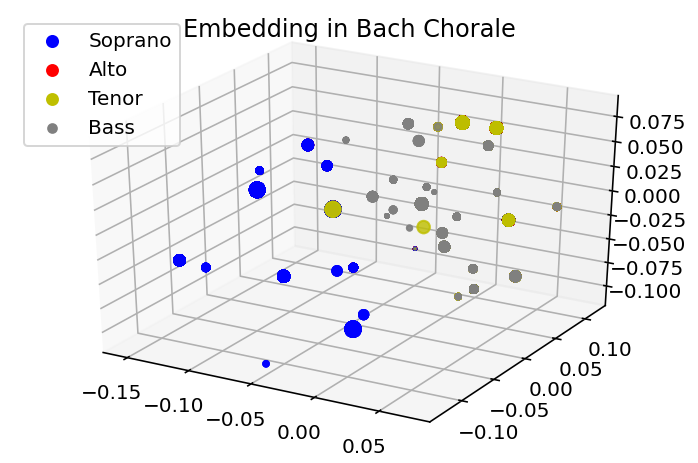

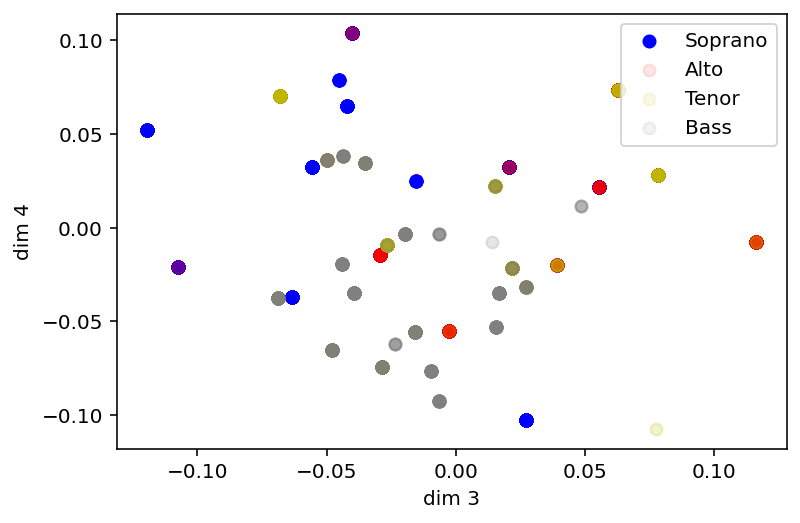

In [ ]:
model_load = keras.models.load_model("/content/drive/My Drive/music_bach_chorales.h5")
inputs = keras.Input(shape=(None, 128))
outputs = model_load.get_layer('embedding')(inputs)
m = keras.Model(inputs,outputs)
m.compile(loss='mse', optimizer='rmsprop')                                                                                                                                                                                                                                        
out = m.predict(test_data[0:30])
print(test_data[0])#out[0])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(out[:,0::4,0], out[:,0::4,1], out[:,0::4,2], s=abs(out[:,0::4,3])*500, color = 'b') #alpha=out[:,0,3]
img = ax.scatter(out[:,1::4,0], out[:,1::4,1], out[:,1::4,2], s=abs(out[:,1::4,3])*500, color = 'r')#, alpha = 0.1) #alpha=out[:,0,3]
img = ax.scatter(out[:,2::4,0], out[:,2::4,1], out[:,2::4,2], s=abs(out[:,2::4,3])*500, color = 'y')#, alpha = 0.01) #alpha=out[:,0,3]
img = ax.scatter(out[:,3::4,0], out[:,3::4,1], out[:,3::4,2], s=abs(out[:,3::4,3])*500, color = 'grey')#,alpha = 0.01) #alpha=out[:,0,3]
#for i in range(128):
#    ax.text(out[0,i,0], out[0,i,1], out[0,i,2], str(train_x[189,i]))
plt.title("Embedding in Bach Chorale")
plt.legend(["Soprano","Alto","Tenor","Bass"],loc="upper left")
#fig.colorbar(img)
#plt.show()
plt.savefig("/content/drive/My Drive/bach_embedding",dpi=350)
fig = plt.figure()
plt.scatter(out[:,0::4,3],out[:,0::4,4], color = 'b') #alpha=out[:,0,3]
plt.scatter(out[:,1::4,3],out[:,1::4,4], color = 'r',alpha =0.1) #alpha=out[:,0,3]
plt.scatter(out[:,2::4,3],out[:,2::4,4], color = 'y',alpha =0.1) #alpha=out[:,0,3]
plt.scatter(out[:,3::4,3],out[:,3::4,4], color = 'grey',alpha =0.1) #alpha=out[:,0,3]

plt.legend(["Soprano","Alto","Tenor","Bass"])
plt.xlabel("dim 3")
plt.ylabel("dim 4")